In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
tfds.disable_progress_bar()

In [3]:
embedding_layer = tf.keras.layers.Embedding(1000, 5)

In [4]:
result = embedding_layer(tf.constant([1, 2, 3]))
result.numpy()

array([[ 0.03468472, -0.00533147,  0.04026114, -0.02045738, -0.0430477 ],
       [-0.04905209, -0.01952353, -0.00417323, -0.04221625, -0.0111053 ],
       [ 0.02062475, -0.00154465,  0.04502643, -0.03934557, -0.02605118]],
      dtype=float32)

In [5]:
result = embedding_layer(tf.constant([[0, 1, 2], [3, 4, 5]]))
result.shape

TensorShape([2, 3, 5])

In [6]:
### Learning embeddings from scratch
(train_data, test_data), info = tfds.load(
    'imdb_reviews/subwords8k',
    split = (tfds.Split.TRAIN, tfds.Split.TEST),
    with_info=True,
    as_supervised=True
)

In [7]:
# SubwordTextEncoder

encoder = info.features['text'].encoder
encoder.subwords[:20]

['the_',
 ', ',
 '. ',
 'a_',
 'and_',
 'of_',
 'to_',
 's_',
 'is_',
 'br',
 'in_',
 'I_',
 'that_',
 'this_',
 'it_',
 ' /><',
 ' />',
 'was_',
 'The_',
 'as_']

In [8]:
train_data

<DatasetV1Adapter shapes: ((None,), ()), types: (tf.int64, tf.int64)>

In [9]:
train_batches = train_data.shuffle(1000).padded_batch(10, padded_shapes=([None], []))
test_batches = test_data.shuffle(1000).padded_batch(10, padded_shapes=([None], []))

In [10]:
train_batch, train_labels = next(iter(train_batches))
train_batch.numpy()

array([[2079,   36, 7998, ...,    0,    0,    0],
       [ 131,  129,   13, ...,    0,    0,    0],
       [ 201,   23,   14, ...,    0,    0,    0],
       ...,
       [6691,  246, 3271, ...,    0,    0,    0],
       [ 147,    4, 1275, ...,    0,    0,    0],
       [1869,  350,   32, ...,    0,    0,    0]])

In [11]:
embedding_dim = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, embedding_dim), 
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          130960    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 131,249
Trainable params: 131,249
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)
history = model.fit(
    train_batches,
    epochs=10,
    validation_data=test_batches, 
    validation_steps=20
)

def train_simple():
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    history = model.fit(
        train_batches,
        epochs=10,
        validation_data=test_batches, 
        validation_steps=20
    )
    
    return model, history

# model, history = train_simple()

Epoch 1/10
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5061 - accuracy: 0.6979 - val_loss: 0.4106 - val_accuracy: 0.8250
Epoch 2/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2867 - accuracy: 0.8818 - val_loss: 0.3691 - val_accuracy: 0.8600
Epoch 3/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.2295 - accuracy: 0.9088 - val_loss: 0.4133 - val_accuracy: 0.8800
Epoch 4/10
2500/2500 [==============================] - 6s 3ms/step - loss: 0.1970 - accuracy: 0.9229 - val_loss: 0.3646 - val_accuracy: 0.8650
Epoch 5/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1740 - accuracy: 0.9359 - val_loss: 0.3614 - val_accuracy: 0.8750
Epoch 6/10
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1579 - accuracy: 0.9432 - val_loss: 0.4558 - val_accuracy: 0.8750
Epoch 7/10
2500/2500 [==============================] - 6s 3ms/step - loss: 0.1414 - accuracy: 0.9472 - val_loss: 0.4164 - val_accuracy

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (15, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

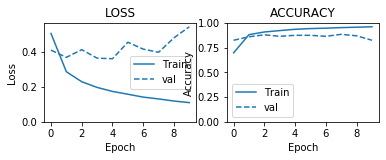

In [14]:
def plot_metrics(history):
    metrics = ['loss', 'accuracy']
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_", " ").capitalize()
        plt.subplot(2, 2, n+1)
        plt.plot(
            history.epoch, 
            history.history[metric], 
            color=colors[0], 
            label='Train'
        )
        plt.plot(
            history.epoch, 
            history.history['val_' + metric], 
            color=colors[0], 
            linestyle="--", 
            label='val'
        )
        plt.title(metric.upper())
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if(metric == 'loss'):
            plt.ylim([0, plt.ylim()[1]])
        elif(metric == 'auc'):
            plt.ylim([0, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()
        
plot_metrics(history)

In [15]:
e = model.layers[0]
print(f"Layer Count: {len(model.layers)}")

Layer Count: 4


In [16]:
weights = e.get_weights()[0]
print(weights.shape)

(8185, 16)


In [17]:
import io

encoder = info.features['text'].encoder

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

for num, word in enumerate(encoder.subwords):
    vec = weights[num + 1]
    out_m.write(word + '\n')
    out_v.write('\t'.join([str(x) for x in vec]) + "\n")
    
out_v.close()
out_m.close()

## Text Classification

In [18]:
print(f'Vocabulary size: {encoder.vocab_size}')

Vocabulary size: 8185


In [19]:
sample_string = "Hello Tensorflow"
encoded_string = encoder.encode(sample_string)
print(f"Encoded String is {encoded_string}")

Encoded String is [4025, 222, 6307, 2327, 2934]


In [20]:
original_string = encoder.decode(encoded_string)
print(f"Original String is {original_string}")

Original String is Hello Tensorflow


In [21]:
for index in encoded_string:
    print(f"{index} ---> {encoder.decode([index])}")

4025 ---> Hell
222 ---> o 
6307 ---> Ten
2327 ---> sor
2934 ---> flow


In [22]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [23]:
# Data Preparation
# train_data, test_data
train_dataset = (train_data.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None], [])))
test_dataset = (test_data.padded_batch(BATCH_SIZE, padded_shapes=([None], [])))

In [24]:
# train_dataset = (train_data.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE))
# test_dataset = (test_data.padded_batch(BATCH_SIZE))

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [27]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)

Epoch 1/10
391/391 [==============================] - 616s 2s/step - loss: 0.6570 - accuracy: 0.5396 - val_loss: 0.4856 - val_accuracy: 0.7344
Epoch 2/10
391/391 [==============================] - 647s 2s/step - loss: 0.3591 - accuracy: 0.8419 - val_loss: 0.3709 - val_accuracy: 0.8396
Epoch 3/10
391/391 [==============================] - 681s 2s/step - loss: 0.2518 - accuracy: 0.8995 - val_loss: 0.3286 - val_accuracy: 0.8547
Epoch 4/10
391/391 [==============================] - 701s 2s/step - loss: 0.2095 - accuracy: 0.9217 - val_loss: 0.3289 - val_accuracy: 0.8615
Epoch 5/10
391/391 [==============================] - 668s 2s/step - loss: 0.1878 - accuracy: 0.9310 - val_loss: 0.3943 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 656s 2s/step - loss: 0.1597 - accuracy: 0.9429 - val_loss: 0.3666 - val_accuracy: 0.8719
Epoch 7/10
391/391 [==============================] - 636s 2s/step - loss: 0.1420 - accuracy: 0.9499 - val_loss: 0.3816 - val_accuracy: 0.8667

In [31]:
test_loss, test_acc = model.evaluate(test_dataset)


    391/Unknown - 106s 270ms/step - loss: 0.3998 - accuracy: 0.8294

In [32]:
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

Test Loss: 0.3998409665530295
Test Accuracy: 0.8293600082397461


In [33]:
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

def sample_predict(sample_pred_text, pad):
    encoded_sample_pred_text = encoder.encode(sample_pred_text)
    
    if(pad):
        encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
    encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
    predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))
    
    return (predictions)

In [34]:
sample_pred_text = ('The move was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie'
                   )
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-0.34882498]]


In [35]:
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.451206]]


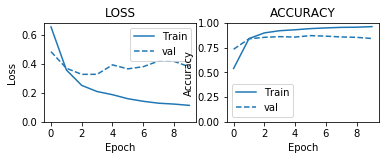

In [36]:
plot_metrics(history)

## LSTM Layers

In [38]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [39]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

history = model.fit(
    train_dataset, epochs=10,
    validation_data=test_dataset,
    validation_steps=30
)

Epoch 1/10
391/391 [==============================] - 1262s 3s/step - loss: 0.6767 - accuracy: 0.5224 - val_loss: 0.5362 - val_accuracy: 0.7557
Epoch 2/10
391/391 [==============================] - 2428s 6s/step - loss: 0.4137 - accuracy: 0.8272 - val_loss: 0.3662 - val_accuracy: 0.8615
Epoch 3/10
391/391 [==============================] - 10596s 27s/step - loss: 0.2877 - accuracy: 0.8918 - val_loss: 0.3349 - val_accuracy: 0.8604
Epoch 4/10
391/391 [==============================] - 1171s 3s/step - loss: 0.2257 - accuracy: 0.9216 - val_loss: 0.4004 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 1266s 3s/step - loss: 0.1890 - accuracy: 0.9376 - val_loss: 0.4001 - val_accuracy: 0.8646
Epoch 6/10
391/391 [==============================] - 1488s 4s/step - loss: 0.1640 - accuracy: 0.9488 - val_loss: 0.4168 - val_accuracy: 0.8505
Epoch 7/10
391/391 [==============================] - 1228s 3s/step - loss: 0.1528 - accuracy: 0.9539 - val_loss: 0.4386 - val_accurac

In [40]:
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

    391/Unknown - 239s 611ms/step - loss: 0.5108 - accuracy: 0.8531Test Loss: 0.5107880719482442
Test Accuracy: 0.8530799746513367


In [41]:
neg_text = ('The movie was not good. The animation and the graphics were terrible. I would not recommend this movie')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.3578727]]


In [42]:
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[2.768681]]


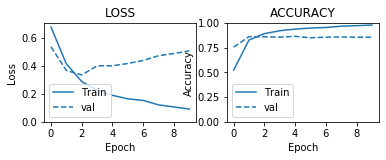

In [43]:
plot_metrics(history)

In [44]:
sample_pred_text

'The move was cool. The animation and the graphics were out of this world. I would recommend this movie'